# Post-hoc Attention Maps

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn import preprocessing
from PIL import Image
import time
import os
import copy
from collections import Counter

In [2]:
tabular_data = "../../data/SkidSteer_2019-08.csv"
color = pd.read_csv('../colorfulness/skid_steer_color_score.csv')

df = pd.read_csv(tabular_data, index_col=1)
df['Unique_ID'] = df[['Source','item#']].apply(lambda x: '_'.join(x),axis = 1)
df = df.filter(['Unique_ID','Winning Bid','Hours Final','Age at Sale (bin)','Bucket','Engine','Tires','Transmission'], axis = 1)
df = pd.merge(df, color,on='Unique_ID',how='inner')
df = df.rename(columns={
    'Unique_ID': "unique_id",
    'Hours Final': "hours_final",
    'Winning Bid': "winning_bid",
    'Age at Sale (bin)': "age_at_sale",
    'Bucket': "bucket",
    'Engine': "engine",
    'Tires': "tires",
    'Transmission': "transmission", 
    'socre': "colorfulness_score"
})
# color = pd.read_csv('skid_steer_color_score.csv')
# final_df = pd.merge(new_df, color,on='Unique_ID',how='inner')


### removal
# remove duplicant
duplicated_item = [item for item, count in Counter(df["unique_id"]).items() if count > 1]
df = df[~df['unique_id'].isin(duplicated_item)]

# remove not matched rows
image_item = [img_name.strip(".jpg") for img_name in os.listdir("../../data/images/")]
df = df[df["unique_id"].isin(image_item)]

# remove comma
df["winning_bid"] = df["winning_bid"].str.replace(',', '').astype(int)

# remove special image
df = df[df['unique_id'] != "rbauction_10525632"]

In [3]:
### winning_bid

# log-transform
df["winning_bid"] = np.log(df["winning_bid"])

# min max scale
mm_scaler_price = preprocessing.MinMaxScaler((-1, 1))
df["winning_bid"] = mm_scaler_price.fit_transform(df["winning_bid"].to_numpy().reshape(-1, 1))

In [4]:
### hours_final

# impute nan with median and new binary indicator
df["hours_final"] = df["hours_final"].str.replace(",", "")
df["hours_final"] = df["hours_final"].astype(float)
df.insert(3, column="hours_final_nan", value=df["hours_final"].isna().astype(int))
df.loc[df["hours_final"].isna(), "hours_final"] = df["hours_final"].median(skipna=True)

# log transform
df["hours_final"] = np.log(df["hours_final"])

# normalize
rb_scaler_hour = preprocessing.RobustScaler()
df["hours_final"] = rb_scaler_hour.fit_transform(np.array(df["hours_final"]).reshape(-1, 1))

In [5]:
### age_at_sale

# impute nan with median and new binary indicator
df["age_at_sale"] = df["age_at_sale"].astype(float)
df.insert(5, column="age_at_sale_nan", value=df["age_at_sale"].isna().astype(int))
df.loc[df["age_at_sale"].isna(), "age_at_sale"] = df["age_at_sale"].median(skipna=True)

# normalize
rb_scaler_age = preprocessing.RobustScaler()
df["age_at_sale"] = rb_scaler_age.fit_transform(np.array(df["age_at_sale"]).reshape(-1, 1))

In [6]:
### bucket
df.insert(7, column="bucket_bin", value=0)
df.loc[
    ~df["bucket"].isna() & 
    df["bucket"].str.contains("bucket", case=False) | 
    df["bucket"].str.contains("bkt", case=False), "bucket_bin"
] = 1

In [7]:
# shuffle and split
np.random.seed(1)
split = [0.7, 0.3]
split0 = round(df.shape[0] * split[0])
# split1 = round(df.shape[0] * (split[0] + split[1]))
df = df.sample(frac=1)
df_train = df.iloc[:split0]
df_val = df.iloc[split0:]

In [8]:
df_train.head()

,unique_id,winning_bid,hours_final,hours_final_nan,age_at_sale,age_at_sale_nan,bucket,bucket_bin,engine,tires,transmission,score
5364,ironplanet_1703726,0.105406,-6.732824,0,-0.666667,0,"74"" Wide General Purpose Smooth Edge Bucket",1,NaN,Cushion Tires,NaN,45.382919
3191,PW_DD1289,0.172815,-1.629216,0,-1.000000,0,"Kubota 68""W bucket",1,Kubota V3307-CR four cylinder turbo diesel engine,Titan 12-16.5 NHS tires,Two speed hydrostatic transmission,55.968483
5495,rbauction_10239624,0.219707,-0.164164,0,-0.666667,0,hyd Q/C bkt,1,NaN,NaN,NaN,35.573711
2563,PW_H1380,-0.072566,-0.769452,0,-0.333333,0,"80""W bucket",1,"81 HP, Case 3.2L four cylinder turbo diesel en...",12-16.5 tires,Hydrostatic transmission,38.453826
2883,PW_J8873,-0.305592,-0.416323,0,-0.333333,0,NaN,0,John Deere 5030TT001 3.0L turbo diesel engine,12-16.5 tires,Two speed hydrostatic transmission,72.305753


In [9]:
df_val.head()

,unique_id,winning_bid,hours_final,hours_final_nan,age_at_sale,age_at_sale_nan,bucket,bucket_bin,engine,tires,transmission,score
4563,bigiron_EN9531,0.164709,-0.503074,0,-0.333333,0,"84"" Bucket",1,"4-Cyl Turbo Diesel Engine, 84 Hp","Some Tires Have Cuts (Pictured), Tires- 14-17....",NaN,40.801346
972,rbauction_10693873,-0.861828,-0.443163,0,1.333333,0,bkt,1,NaN,NaN,NaN,19.575992
4915,bigiron_BO0203,-0.180158,-0.226316,0,1.333333,0,"Buckets 12"", 64"" Bucket",1,58 Horse Power Isuzu Diesel Engine,"12-16.5 Tires, Spare Tire And Rim",Hydrostat Transmission,19.348823
5351,ironplanet_1891010,-0.402470,-6.732824,0,-0.333333,0,"72"" Wide General Purpose Smooth Edge Bucket",1,NaN,NaN,NaN,59.205629
2819,PW_J2936,-0.402470,-1.926828,0,-0.333333,0,NaN,0,"Case four cylinder turbo diesel engine, Non-op...",12-16.5 tires,Hydrostatic transmission,27.390935


In [10]:
df_train.to_csv("./SkidSteer_2019-08_clean_train.csv")
df_val.to_csv("./SkidSteer_2019-08_clean_val.csv")

In [11]:
class skidsteer_dataset(Dataset):
    """Corrosion Detection dataset."""

    def __init__(self, 
                 csv_file, 
                 img_root, 
                 transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_root (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample (including augmentation).
        """
        self.csv_file = pd.read_csv(csv_file, index_col=0)
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        '''Return one data point with a PIL image and its label.'''
        img_dir = os.path.join(self.img_root, self.csv_file.iloc[idx, 0]) + ".jpg"
        price = self.csv_file.iloc[idx, 1]
        image = Image.open(img_dir)
        others = torch.tensor(self.csv_file.iloc[idx, [2, 3, 4, 5, 7, 11]])  # change this when new columns are added
        
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'price': price, "others": others}
        return sample

In [12]:
def norm2price(tensor, min_max_scaler):
    array2d = tensor.to("cpu").data.numpy().reshape(-1, 1)
    return np.exp(min_max_scaler.inverse_transform(array2d))

def price_MAE(outputs, prices, min_max_scaler):
    outputs = norm2price(outputs, min_max_scaler)
    prices = norm2price(prices, min_max_scaler)
    mae = np.abs(outputs - prices)
    maep = np.abs(outputs - prices) / prices
    return mae.mean(), mae, maep

In [13]:
def train_model(model, model_LU, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = None
    best_loss = float("Inf")
    best_mae = float("Inf")
    best_mae_list = None
    best_maep_list = None
    all_loss = {x: [] for x in ['train', 'val']}
    all_mae = {x: [] for x in ['train', 'val']}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_mae = 0.0
            running_mae_list = []
            running_maep_list = []
            
            # Iterate over data.
            for items in dataloaders[phase]:
                images = items["image"].to(device)
                prices = items["price"].to(device)
                others = items["others"].to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = cat_net(model, model_LU, images, others).squeeze()
                    loss = criterion(outputs, prices)
                    mae, mae_np, maep_np = price_MAE(outputs, prices, mm_scaler_price)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * images.size(0)
                running_mae += mae * images.size(0)
                running_mae_list += list(mae_np.flatten())
                running_maep_list += list(maep_np.flatten())
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_mae = running_mae / dataset_sizes[phase]
            all_loss[phase].append(epoch_loss)
            all_mae[phase].append(epoch_mae)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print('{} MAE: {:.4f}'.format(phase, epoch_mae))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_epoch = epoch + 1
                best_loss = epoch_loss
                best_mae = epoch_mae
                best_mae_list = running_mae_list
                best_maep_list = running_maep_list
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f} at epoch {}'.format(best_loss, best_epoch))
    print('Best val MAE: {:4f} at epoch {}'.format(best_mae, best_epoch))

    # load best model weights
    print("\nLoad the model weights at the best epoch")
    model.load_state_dict(best_model_wts)
    return model, best_mae_list, all_loss, all_mae

In [14]:
CSV_FILE = {"train": "./SkidSteer_2019-08_clean_train.csv",
            "val": "./SkidSteer_2019-08_clean_val.csv"}
IMG_ROOT = "../../data/images/"
TRANSFORM = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

datasets = {x: skidsteer_dataset(csv_file=CSV_FILE[x],
                                 img_root=IMG_ROOT,
                                 transform=TRANSFORM[x])
            for x in ["train", "val"]}
dataloaders = {x: DataLoader(datasets[x], 
                             batch_size=16, 
                             shuffle=True, 
                             num_workers=4)
               for x in ["train", "val"]}
dataset_sizes = {x: len(datasets[x]) for x in ["train", "val"]}
num_tabular_features = len(datasets["train"][0]["others"])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Class Activation Mapping (CAM)

In [74]:
ids = [2,3,4,4]
temp = datasets['train'].csv_file.columns[ids]

In [82]:
print("%s " % [x for x in temp])

['hours_final', 'hours_final_nan', 'age_at_sale', 'age_at_sale'] 


In [15]:
def cat_net(model_ft, model_LU, images, others):
    z = torch.cat((model_ft(images), others), dim=1)
    return model_LU(z)

def cat_layer_eval(model_ft, images):
    '''Pass through all layers but avgpool and fc.'''
    z = model_ft.conv1(images)
    z = model_ft.bn1(z)
    z = model_ft.relu(z)
    z = model_ft.maxpool(z)
    z = model_ft.layer1(z)
    z = model_ft.layer2(z)
    z = model_ft.layer3(z)
    z = model_ft.layer4(z)
    return z

def cat_net_eval(model_ft, model_LU, images, others):
    '''Always eval one image at a time.'''
    model_ft.eval()
    model_LU.eval()
    # regular output
    z = torch.cat((model_ft(images), others), dim=1)
    y = model_LU(z)
    # attention map
    attention_units = cat_layer_eval(model_ft, images).squeeze()  # (2048, 7, 7)
    num_ftrs = attention_units.size()[0]  # 2048
    weights = model_LU.weight[:, :num_ftrs].clone().squeeze().unsqueeze(dim=1).unsqueeze(dim=2)  # (1, 2048) -> (2048, 1, 1)
    attention_map = torch.mul(weights, attention_units).sum(dim=0).unsqueeze(dim=0).unsqueeze(dim=0).to("cpu").data # (1, 1, 7, 7)
    return y, attention_map

In [18]:
torch.manual_seed(0)

### ResNet18
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Identity()

### Freeze and Fine Tuning
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.layer3.parameters():
    param.requires_grad = True
for param in model_ft.layer4.parameters():
    param.requires_grad = True
assert [param.requires_grad for param in model_ft.parameters()][-1]

### LU
model_LU = nn.Linear(num_ftrs + num_tabular_features, 1, bias=True)

### model setup
model_ft = model_ft.to(device)
model_LU = model_LU.to(device)
criterion = nn.MSELoss()
# Observe that all parameters are being optimized
params = list(model_ft.parameters()) + list(model_LU.parameters())
optimizer_ft = optim.SGD(params, lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20)

In [19]:
model_res152, mae_list_0, all_loss_0, all_mae_0 = train_model(model_ft, model_LU, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train Loss: 2.2598
train MAE: 1271943.6528


KeyboardInterrupt: 

In [18]:
upTrans = nn.Upsample(scale_factor=32, mode="bilinear", align_corners=True)

invTrans = transforms.Compose([
    transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])
])

In [24]:
def eval_model_CAM(model_ft, model_LU, idx=("val", None)):
    # read and eval
    if idx[1]:
        inputs = datasets[idx[0]][idx[1]]
    else:
        i = np.random.randint(len(datasets[idx[0]]))
        print("idx = %d" % i)
        inputs = datasets[idx[0]][i]
    img_tensor = inputs["image"]
    price = inputs["price"]
    others = inputs["others"]
    img_original = invTrans(img_tensor) # (3, 224, 224)
    model_ft = model_ft.to("cpu")
    model_LU = model_LU.to("cpu")
    y, attention_map = cat_net_eval(model_ft, model_LU, img_tensor.unsqueeze(dim=0), others.unsqueeze(dim=0))
    
    # price
    price = np.exp(mm_scaler_price.inverse_transform(price.reshape(-1, 1)))
    y = np.exp(mm_scaler_price.inverse_transform(y.squeeze().to("cpu").data.numpy().reshape(-1, 1)))
    print("price = %d, predict = %.2f" % (price, y))
    
    # images
    plt.figure(figsize=(15, 45))
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(img_original.permute(1, 2, 0))
    ax1.set_title("Original")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(upTrans(attention_map).squeeze().data, cmap="coolwarm", vmin=-1., vmax=1.)
    ax2.set_title("Absolute Attention")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(upTrans(attention_map).squeeze().data, cmap="coolwarm", vmin=attention_map.min(), vmax=attention_map.max())
    ax3.set_title("Normalized Attention")
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    # colorbar
    plt.figure(figsize=(15, 0.2))
    ax = plt.subplot(1, 1, 1)
    cmap = mpl.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    plt.show()
    
    return y, img_original, attention_map

price = 22000, predict = 236952.53


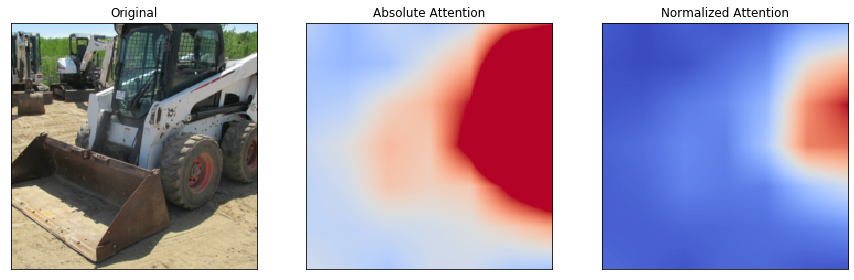

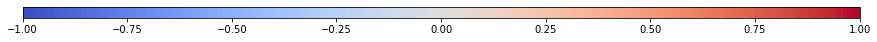

In [31]:
y, img, a_map = eval_model_CAM(model_ft, model_LU, idx=("val", 1442))

In [32]:
# global mean
np.exp(mm_scaler_price.inverse_transform(np.array(datasets["train"].csv_file.winning_bid).reshape(-1, 1))).mean().round(2)

14482.55

## Back Probagation Saliency Map

In [96]:
def eval_model_saliency(model_ft, model_LU, idx=("val", None)):
    # read and eval
    if idx[1]:
        inputs = datasets[idx[0]][idx[1]]
    else:
        i = np.random.randint(len(datasets[idx[0]]))
        print("idx = %d" % i)
        inputs = datasets[idx[0]][i]
    img_tensor = inputs["image"]
    price = inputs["price"]
    others = inputs["others"].requires_grad_()
    img_original = invTrans(img_tensor) # (3, 224, 224)
    
    # forward
    model_ft = model_ft.to("cpu")
    model_ft.eval()
    model_ft.zero_grad()
    model_LU = model_LU.to("cpu")
    model_LU.eval()
    model_LU.zero_grad()
    img_tensor = img_tensor.unsqueeze(dim=0).requires_grad_()
    out = cat_net(model_ft, model_LU, img_tensor, others.unsqueeze(dim=0))
    
    # backward
    out.backward()
    x_grad = img_tensor.grad
    saliency = x_grad.squeeze().max(dim=0).values
    pos_saliency = nn.functional.relu(saliency)
    pos_img = pos_saliency.mul(img_original)
    pos_img = pos_img.div(pos_img.max())
    neg_saliency = nn.functional.relu(-saliency)
    neg_img = neg_saliency.mul(img_original)
    neg_img = neg_img.div(neg_img.max())
    
    # price
    price = np.exp(mm_scaler_price.inverse_transform(price.reshape(-1, 1)))
    y = np.exp(mm_scaler_price.inverse_transform(out.squeeze().to("cpu").data.numpy().reshape(-1, 1)))
    print("price = %d, predict = %.2f" % (price, y))

    # images
    plt.figure(figsize=(20, 60))
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(img_original.permute(1, 2, 0))
    ax1.set_title("Original")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = plt.subplot(1, 4, 2)
    ax2.imshow(saliency, cmap="coolwarm", vmin=-0.004, vmax=0.004)
    ax2.set_title("Absolute Attention")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = plt.subplot(1, 4, 3)
    ax3.imshow(pos_img.permute(1, 2, 0))
    ax3.set_title("Positive Attention")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = plt.subplot(1, 4, 4)
    ax4.imshow(neg_img.permute(1, 2, 0))
    ax4.set_title("Negative Attention")
    ax4.set_xticks([])
    ax4.set_yticks([])
    
    # colorbar
    plt.figure(figsize=(20, 0.2))
    ax = plt.subplot(1, 1, 1)
    cmap = mpl.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    plt.show()
    
    return out, saliency, img_original

price = 22000, predict = 236952.53


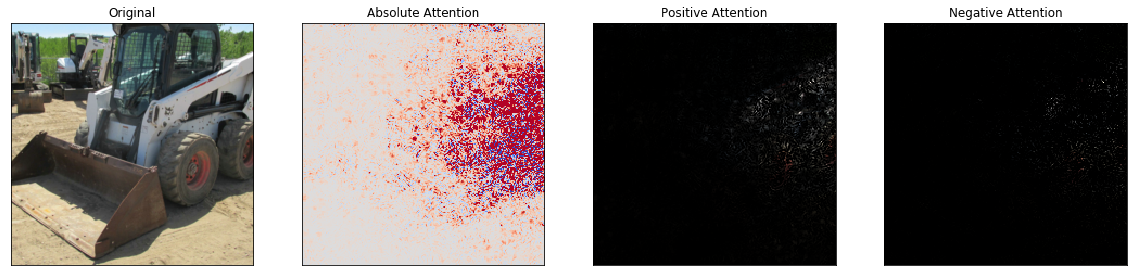

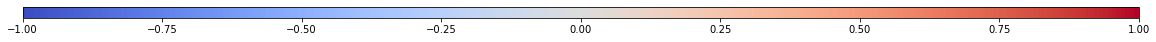

In [97]:
y, saliency, img = eval_model_saliency(model_ft, model_LU, ('val', 1442))

# Guided Grad-CAM 

In [133]:
def eval_model_GCAM(model_ft, model_LU, idx=("val", None)):
    # read and eval
    if idx[1]:
        inputs = datasets[idx[0]][idx[1]]
    else:
        i = np.random.randint(len(datasets[idx[0]]))
        print("idx = %d" % i)
        inputs = datasets[idx[0]][i]
    img_tensor = inputs["image"]
    price = inputs["price"]
    others = inputs["others"]
    img_original = invTrans(img_tensor) # (3, 224, 224)
    
    # forward
    model_ft = model_ft.to("cpu")
    model_ft.eval()
    model_ft.zero_grad()
    model_LU = model_LU.to("cpu")
    model_LU.eval()
    model_LU.zero_grad()
    img_tensor = img_tensor.unsqueeze(dim=0).requires_grad_()
    y, attention_map = cat_net_eval(model_ft, model_LU, img_tensor, others.unsqueeze(dim=0))
    out = cat_net(model_ft, model_LU, img_tensor, others.unsqueeze(dim=0))
    
    # backward
    cam = upTrans(attention_map).squeeze().data
    out.backward()
    x_grad = img_tensor.grad
    saliency = x_grad.squeeze().max(dim=0).values
    pos_saliency = nn.functional.relu(saliency)
    pos_cam = cam.mul(pos_saliency)
    pos_cam = pos_cam.div(pos_cam.max())
    neg_saliency = nn.functional.relu(-saliency)
    neg_cam = cam.mul(neg_saliency)
    neg_cam = neg_cam.div(neg_cam.max())
    
    # price
    price = np.exp(mm_scaler_price.inverse_transform(price.reshape(-1, 1)))
    y = np.exp(mm_scaler_price.inverse_transform(y.squeeze().to("cpu").data.numpy().reshape(-1, 1)))
    print("price = %d, predict = %.2f" % (price, y))
    
    # images
    plt.figure(figsize=(20, 60))
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(img_original.permute(1, 2, 0))
    ax1.set_title("Original")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2 = plt.subplot(1, 4, 2)
    ax2.imshow(cam, cmap="coolwarm", vmin=-1., vmax=1.)
    ax2.set_title("Grad-CAM")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = plt.subplot(1, 4, 3)
    ax3.imshow(pos_cam)
    ax3.set_title("positive Guided Grad-CAM")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = plt.subplot(1, 4, 4)
    ax4.imshow(neg_cam)
    ax4.set_title("negative Guided Grad-CAM")
    ax4.set_xticks([])
    ax4.set_yticks([])
    
    
    # colorbar
    plt.figure(figsize=(20, 0.2))
    ax = plt.subplot(1, 1, 1)
    cmap = mpl.cm.coolwarm
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
    plt.show()
    
    return y, img_original, attention_map

price = 22000, predict = 236952.53


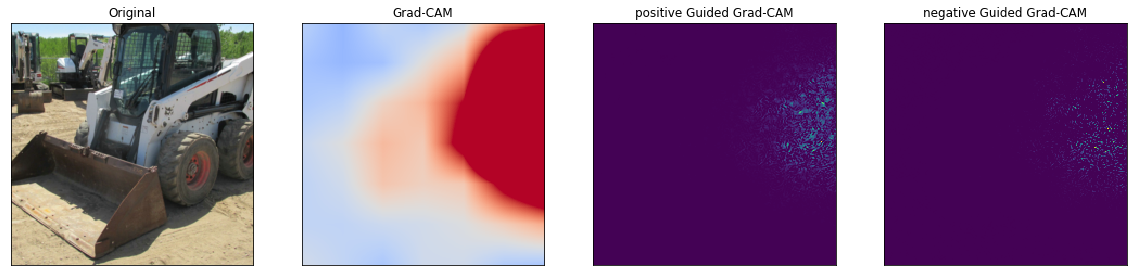

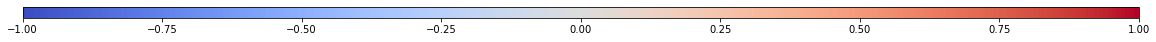

In [134]:
y, img, att = eval_model_GCAM(model_ft, model_LU, ('val', 1442))